In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import json
import os
import openai
from dotenv import load_dotenv, find_dotenv

_ = load_dotenv(find_dotenv())  # read local .env file

import time
import pickle

import handoff_eval

# Load data

In [3]:
data_path = "../data/ai_ml_take_home"
ground_truth_path = os.path.join(data_path, "ground_truth")
model_outputs_path = os.path.join(data_path, "model_outputs")

In [4]:
ground_truth_data = handoff_eval.data_preparation.load_json_files(ground_truth_path)
model_output_data = handoff_eval.data_preparation.load_json_files(model_outputs_path)

# Evaluation run

In [15]:
run_number = 2
# run_number = 3
load_run = True
# load_run = False
save_run = False
# save_run = True

eval_file_path = "../data/evaluations/matched_pairs_dict_" + str(run_number) + ".pkl"

In [16]:
if load_run:
    with open(eval_file_path, "rb") as f:
        matched_pairs_dict = pickle.load(f)

else:
    start_time = time.time()

    async def run_async_processing():
        return await handoff_eval.data_preparation.process_all_models_async(model_output_data, ground_truth_data)

    matched_pairs_dict = await run_async_processing()

    end_time = time.time()
    total_time = end_time - start_time
    print(f"process_all_models_async - total execution time: {total_time:.2f} seconds")

    if save_run:
        # Save the dictionary to a pickle file
        with open(eval_file_path, "wb") as f:
            pickle.dump(matched_pairs_dict, f)
# process_all_models_async - total execution time: 41.90 seconds

# Visualize main metrics by model

2025-03-18 21:24:28,283 - INFO - matplotlib.category - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-18 21:24:28,289 - INFO - matplotlib.category - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


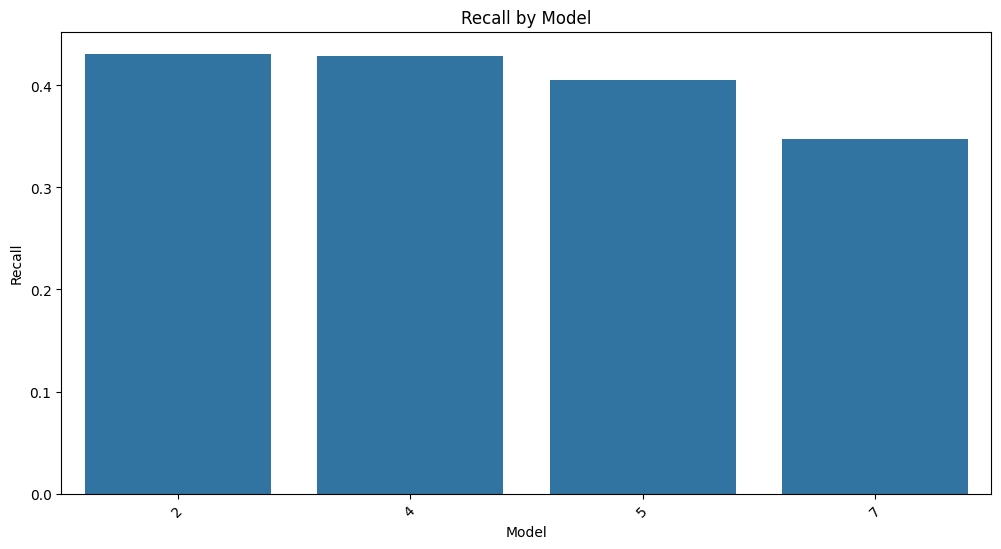

2025-03-18 21:24:28,394 - INFO - matplotlib.category - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-18 21:24:28,399 - INFO - matplotlib.category - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


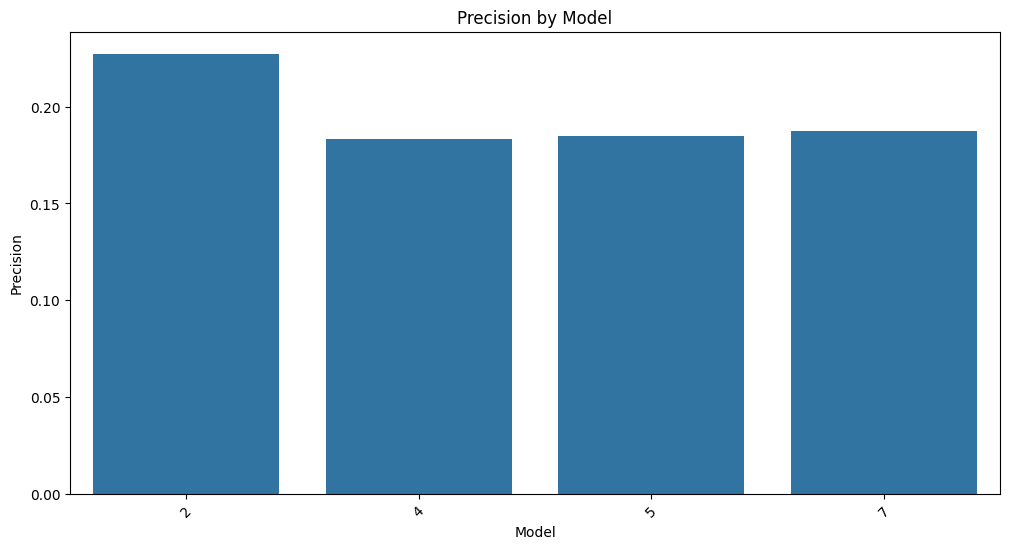

2025-03-18 21:24:28,511 - INFO - matplotlib.category - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-18 21:24:28,516 - INFO - matplotlib.category - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


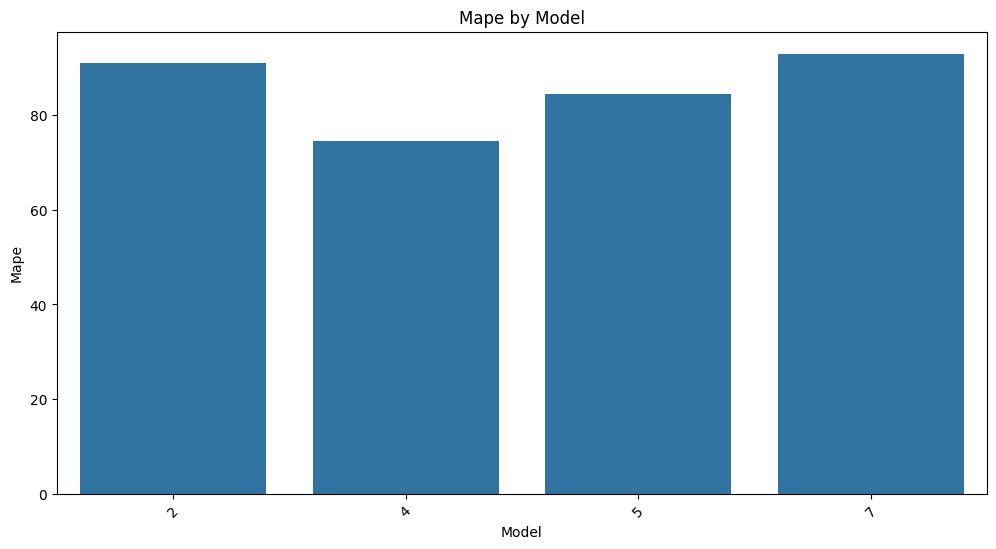

In [17]:
# --- Plotting ---
x = "model"

# Recall
error_type = "recall"
df_metrics = handoff_eval.evaluation.compute_model_metrics_df(matched_pairs_dict, metric=None, error_type=error_type)
handoff_eval.evaluation.plot_model_metrics(df_metrics, x=x, metric_name=error_type.capitalize())

# Precision
error_type = "precision"
df_metrics = handoff_eval.evaluation.compute_model_metrics_df(matched_pairs_dict, metric=None, error_type=error_type)
handoff_eval.evaluation.plot_model_metrics(df_metrics, x=x, metric_name=error_type.capitalize())

# Mape of rowTotalCostUsd
metric = "rowTotalCostUsd"
error_type = "mape"
df_metrics = handoff_eval.evaluation.compute_model_metrics_df(matched_pairs_dict, metric=metric, error_type=error_type)
handoff_eval.evaluation.plot_model_metrics(df_metrics, x=x, metric_name=error_type.capitalize())

# Investigate main metrics by example for each model

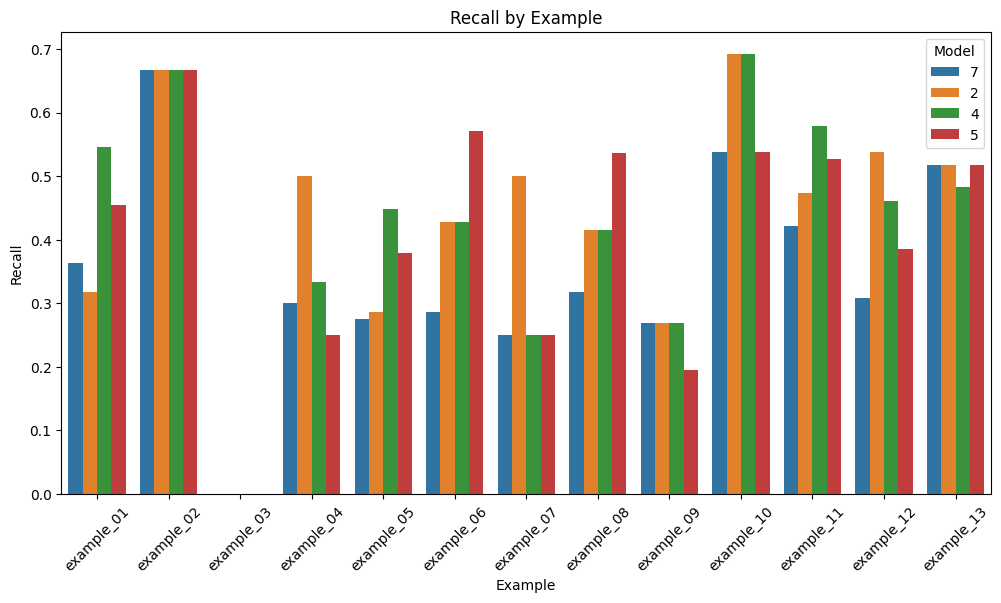

In [53]:
x = "example"
# Recall
error_type = "recall"
df_metrics = handoff_eval.evaluation.compute_model_metrics_df(matched_pairs_dict, metric=None, error_type=error_type)
handoff_eval.evaluation.plot_model_metrics(df_metrics, x=x, metric_name=error_type.capitalize())

In [19]:
# Find best model based on best f1 and best MAPE
agg_recall, _ = handoff_eval.evaluation.aggregate_by_model(df_metrics)
agg_recall

,model,value
0,2,90.945837
1,4,74.494476
2,5,84.459799
3,7,92.967552


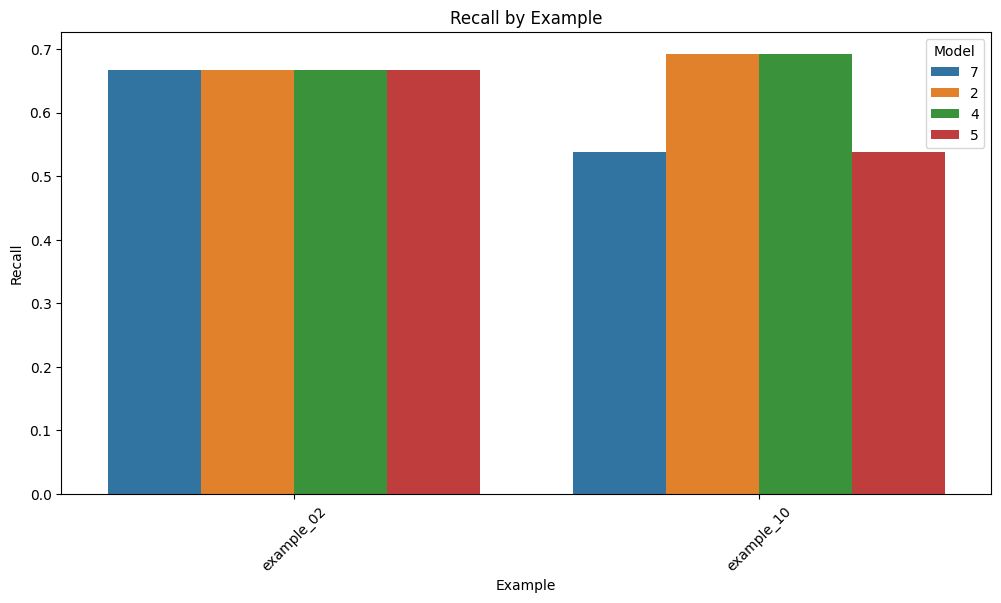

In [54]:
# Plot after filtering specific examples and models
x = "example"
# Recall
error_type = "recall"
filtered_df = handoff_eval.evaluation.filter_metrics(df_metrics, example_list=["example_02", "example_10"], model_list=["2", "4", "5", "7"])
handoff_eval.evaluation.plot_model_metrics(filtered_df, x=x, metric_name=error_type.capitalize())

In [56]:
# print(matched_pairs_dict["2"]["example_01"]["matched_pairs_data"])
ground_truth_data["example_02"]["input"]

"I have a utility room which needs sound insulation and drywall on one wall. I would like this wall painted also. Wall is 20'x10'."

In [60]:
matched_pairs_dict["2"]["example_01"]["matched_pairs_data"].iloc[:5]

,gt_label,gt_sectionName,gt_uom,gt_category,gt_qty,gt_rateUsd,gt_rowTotalCostUsd,pred_label,pred_sectionName,pred_uom,pred_category,pred_qty,pred_rateUsd,pred_rowTotalCostUsd,similar_task,justification,label_cat
0,Install Toilet,Plumbing,EA,other,1.0,400.0,400.0,Toilet,Plumbing,EA,material,1.0,250.0,250.0,1,"yes, both labels refer to the task involving a...",toilet
1,Install Wall Tile,Tile,SF,other,66.0,16.0,1056.0,Shower Wall Tile,Tile,SF,material,150.0,8.0,1200.0,1,"yes, both labels refer to the task of tiling w...",other
2,Install Floor Tile,Tile,SF,other,73.0,16.0,1168.0,Bathroom Floor Tile,Tile,SF,material,74.0,8.0,592.0,1,"yes, both labels describe the task of installi...",other
3,Paint Ceiling - 3 Coats,Painting,SF,other,73.0,2.4,175.2,Prepare Ceiling Surfaces for Paint,Painting,SF,material,75.0,0.3,22.5,0,"no, these labels describe different stages of ...",other
4,Paint Walls - 3 Coats,Painting,SF,other,288.0,2.4,691.2,Prepare Wall Surfaces for Paint,Painting,SF,material,188.0,0.3,56.4,0,"no, these labels describe different tasks; the...",other


In [61]:
df_metrics.head()

,example,model,metric,error_type,value
0,example_03,7,recall,recall,0.000000
1,example_02,7,recall,recall,0.666667
2,example_01,7,recall,recall,0.363636
3,example_04,7,recall,recall,0.300000
4,example_06,7,recall,recall,0.285714


# Simple example to illustrate the methodology

In [20]:
from handoff_eval.constants import LINE_ITEM_INFO
sel_cols = [col for pair in [(f"gt_{key}", f"pred_{key}") for key in LINE_ITEM_INFO] for col in pair]

In [21]:
matched_pairs_dict["2"]["example_01"]["matched_pairs_data"][sel_cols].head()

,gt_label,pred_label,gt_sectionName,pred_sectionName,gt_uom,pred_uom,gt_category,pred_category,gt_qty,pred_qty,gt_rateUsd,pred_rateUsd,gt_rowTotalCostUsd,pred_rowTotalCostUsd
0,Install Toilet,Toilet,Plumbing,Plumbing,EA,EA,other,material,1.0,1.0,400.0,250.0,400.0,250.0
1,Install Wall Tile,Shower Wall Tile,Tile,Tile,SF,SF,other,material,66.0,150.0,16.0,8.0,1056.0,1200.0
2,Install Floor Tile,Bathroom Floor Tile,Tile,Tile,SF,SF,other,material,73.0,74.0,16.0,8.0,1168.0,592.0
3,Paint Ceiling - 3 Coats,Prepare Ceiling Surfaces for Paint,Painting,Painting,SF,SF,other,material,73.0,75.0,2.4,0.3,175.2,22.5
4,Paint Walls - 3 Coats,Prepare Wall Surfaces for Paint,Painting,Painting,SF,SF,other,material,288.0,188.0,2.4,0.3,691.2,56.4


In [22]:
import pandas as pd
pd.set_option("display.max_colwidth", None)  # Show full text in all columns

matched_pairs_dict["2"]["example_01"]["matched_pairs_data"][sel_cols[:8] + ["similar_task", "justification"]].head(10)

,gt_label,pred_label,gt_sectionName,pred_sectionName,gt_uom,pred_uom,gt_category,pred_category,similar_task,justification
0,Install Toilet,Toilet,Plumbing,Plumbing,EA,EA,other,material,1,"yes, both labels refer to the task involving a toilet, with ""install toilet"" specifying the action of installation, and ""toilet"" likely implying work related to a toilet, such as installation or replacement."
1,Install Wall Tile,Shower Wall Tile,Tile,Tile,SF,SF,other,material,1,"yes, both labels refer to the task of tiling walls, with the second specifying the location as the shower."
2,Install Floor Tile,Bathroom Floor Tile,Tile,Tile,SF,SF,other,material,1,"yes, both labels describe the task of installing tile on a floor, with the second specifying the location as a bathroom."
3,Paint Ceiling - 3 Coats,Prepare Ceiling Surfaces for Paint,Painting,Painting,SF,SF,other,material,0,"no, these labels describe different stages of a task; the first is about applying paint, while the second is about preparing the surface before painting."
4,Paint Walls - 3 Coats,Prepare Wall Surfaces for Paint,Painting,Painting,SF,SF,other,material,0,"no, these labels describe different tasks; the first involves the actual painting of walls, while the second refers to the preparatory work needed before painting can begin."
5,Demo Shower Surround,Protect Work Area and Surroundings,Demolition,Demolition,SF,SF,other,labor,0,"no, these labels describe different tasks; the first involves demolishing an existing shower surround, while the second involves safeguarding the work area and its surroundings from damage during construction."
6,Demo Vanity,Demo Vanity,Demolition,Demolition,EA,HRS,other,labor,1,"yes, the labels are identical and refer to the same task of demolishing a vanity."
7,Demo Tub,Demo Tub,Demolition,Demolition,EA,HRS,other,labor,1,"yes, both labels describe the exact same task of demolishing a bathtub."
8,Demo Plumbing Fixtures,Disposal Costs,Demolition,Demolition,EA,EA,other,labor plus material,0,"no, these labels do not describe the same type of work; ""demo plumbing fixtures"" refers to the removal or demolition of plumbing fixtures, while ""disposal costs"" pertains to the expenses associated with disposing of materials."
9,Install Shower Pan,Pipe Fittings and Adhesives,Plumbing,Plumbing,EA,EA,other,material,0,"no, these labels refer to different tasks; ""install shower pan"" focuses on setting up the base of a shower, while ""pipe fittings and adhesives"" relates to connecting and securing piping systems."


In [23]:
pd.reset_option("display.max_colwidth")